# The "Catering Capacity": A Model by Meg and Sparsh


Project 1

In [40]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim library
from modsim import *

In [41]:
from pandas import read_html

filename = 'data/World_population_estimates.html'
tables = read_html(filename, header=0, index_col=0, decimal='M')
table2 = tables[2]
table2.columns = ['census', 'prb', 'un', 'maddison', 
                  'hyde', 'tanton', 'biraben', 'mj', 
                  'thomlinson', 'durand', 'clark']

In [42]:
def plot_results(census, un, timeseries, title):
    """Plot the estimates and the model.
    
    census: TimeSeries of population estimates
    un: TimeSeries of population estimates
    timeseries: TimeSeries of simulation results
    title: string
    """
    plot(census, ':', label='US Census')
    plot(un, '--', label='UN DESA')
    if len(timeseries):
        plot(timeseries, color='gray', label='model')
    
    decorate(xlabel='Year', 
             ylabel='World population (billion)',
             title=title)

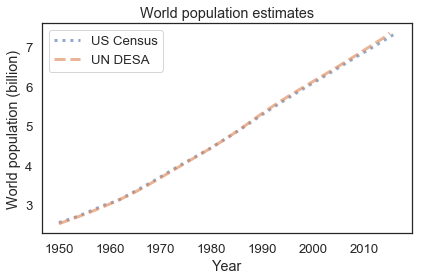

In [43]:
un = table2.un / 1e9
census = table2.census / 1e9
empty = TimeSeries()
plot_results(census, un, empty, 'World population estimates')

# How does world food production affect earth's ability to actually reach the carrying capacity of 13.8888889 billion by 2050? 

Since 1970, the food population has been growing fairly quadratically, as shown in the figure. Will there be enough food to cater to the population at the equilibrium point?

Will we be able to decrease the amount of food wasted to meet the future food demands?

To explore this question, we will model the carrying capacity and the food production rate, which we call the catering capacity.

We'll use our projection of the world population from 1950 to 2050, and compare it to the model's projected catering capacity of from 1950 till 2050.

# Method 1: 
(i) Yield of Vegetables per hectare 
(ii) Total area used for crop production
(iii) Average quantity of food consumed by humans

In [44]:
from pandas import read_csv
food_data = read_csv("FAOSTAT_data_9-24-2018.csv")
food_data.columns = ['Year', 'Unit', 'Value', 'Food production in billions of hg', 'Food production in billions of pounds',  'Catering_Capacity_in_billions_of_people']
print(food_data)

    Year   Unit   Value  Food production in billions of hg  \
0   1961  hg/ha   93453                           140179.5   
1   1962  hg/ha   94179                           141268.5   
2   1963  hg/ha   95289                           142933.5   
3   1964  hg/ha   97564                           146346.0   
4   1965  hg/ha   99493                           149239.5   
5   1966  hg/ha  102568                           153852.0   
6   1967  hg/ha  105748                           158622.0   
7   1968  hg/ha  108703                           163054.5   
8   1969  hg/ha  109348                           164022.0   
9   1970  hg/ha  110418                           165627.0   
10  1971  hg/ha  113656                           170484.0   
11  1972  hg/ha  112133                           168199.5   
12  1973  hg/ha  115999                           173998.5   
13  1974  hg/ha  117963                           176944.5   
14  1975  hg/ha  118713                           178069.5   
15  1976

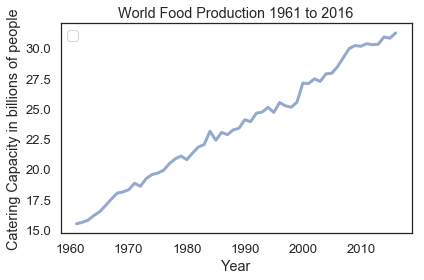

In [45]:
plot(food_data.Year, food_data.Catering_Capacity_in_billions_of_people)
decorate(title = "World Food Production 1961 to 2016",
        xlabel = "Year",
        ylabel = "Catering Capacity in billions of people")

# Linear Growth Model

In [148]:
Catering_Capacity_in_billions_of_people = food_data.Catering_Capacity_in_billions_of_people
Year = food_data.Year
food_data.head()

,Year,Unit,Value,Food production in billions of hg,Food production in billions of pounds,Catering_Capacity_in_billions_of_people
0,1961,hg/ha,93453,140179.5,30904.28968,15.483111
1,1962,hg/ha,94179,141268.5,31144.37309,15.603393
2,1963,hg/ha,95289,142933.5,31511.44275,15.787296
3,1964,hg/ha,97564,146346.0,32263.77022,16.164214
4,1965,hg/ha,99493,149239.5,32901.67778,16.483807


In [149]:
t_0 = get_first_value(Year)
t_end = get_last_value(Year)
elapsed_time = t_end - t_0

p_0 = get_first_value(Catering_Capacity_in_billions_of_people)
p_end = get_last_value(Catering_Capacity_in_billions_of_people)
total_growth = p_end - p_0
alpha = 0
annual_growth = total_growth / elapsed_time

0.28667725327272725

In [150]:
system = System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                annual_growth=annual_growth,
               alpha=alpha)

,values
t_0,1961.000000
t_end,2016.000000
p_0,15.483111
annual_growth,0.286677
alpha,0.000000


In [151]:
def run_simulation(system):
    """Runs the constant growth model.
    
    system: System object
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        results[t+1] = results[t] + system.annual_growth
    
    return results

In [152]:
def plot_results2(Catering_Capacity_in_billions_of_people, timeseries, title):
    """Plot the estimates and the model.
    
    Catering_Capacity_in_billions_of_people: TimeSeries of food production / per capita food needs
    timeseries: TimeSeries of simulation results
    title: string
    """
    plot(food_data.Year, Catering_Capacity_in_billions_of_people, ':', label='Catering Capacity (billions)')
    plot(timeseries, color='gray', label='model')
    
    decorate(xlabel='Year', 
             ylabel='World Food Production',
             title=title)

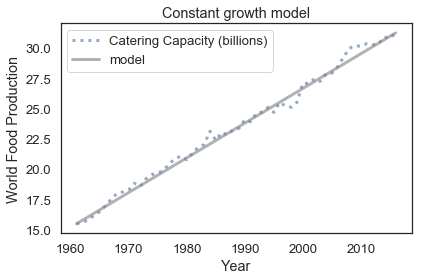

In [153]:
results = run_simulation(system)
plot_results2(Catering_Capacity_in_billions_of_people, results, 'Constant growth model')

# Proportional Growth Model

In [154]:
def run_simulation2(system, update_func):
    """Run a model with proportional produce and waste.
    
    system: System object
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        results[t+1] = update_func(results[t], t, system)
        
    return results

In [155]:
def update_func1(food, t, system):
    produce = system.produce * food
    waste = system.waste * food
    return food + produce - waste

In [156]:
system.produce = 0.0265
system.waste = 0.012

In [157]:
results = run_simulation2(system, update_func1)

,values
1961,15.483111
1962,15.707616
1963,15.935377
1964,16.166440
1965,16.400853
1966,16.638665
1967,16.879926
1968,17.124685
1969,17.372993
1970,17.624901


Saving figure to file figs/chap03-fig03.pdf


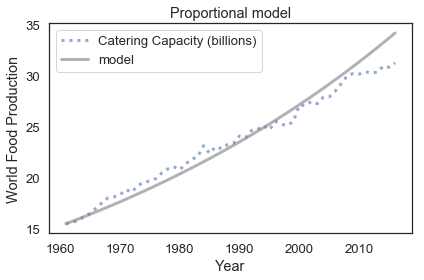

In [158]:
plot_results2(Catering_Capacity_in_billions_of_people, results, 'Proportional model')
savefig('figs/chap03-fig03.pdf')

In [159]:
def update_func2(food, t, system):
    """Compute the catering capacity next year.
    
    pop: current food availability
    t: current year
    system: system object containing parameters of the model
    
    returns: catering capacity next year
    """
    net_growth = system.alpha  * food
    return food + net_growth

In [160]:
system.alpha = system.produce - system.waste
results = run_simulation2(system, update_func2)

,values
1961,15.483111
1962,15.707616
1963,15.935377
1964,16.166440
1965,16.400853
1966,16.638665
1967,16.879926
1968,17.124685
1969,17.372993
1970,17.624901


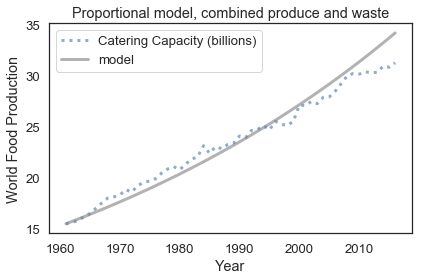

In [166]:
plot_results2(Catering_Capacity_in_billions_of_people, results, 'Proportional model, combined produce and waste')

# Quadratic Growth Model

In [170]:
def update_func_quad(food, t, system):
    """Compute the catering capacity next year with a quadratic model.
    
    food: current catering capacityn
    t: current year
    system: system object containing parameters of the model
    
    returns: capacity next year
    """
    net_growth = system.alpha * food + system.beta * food**2
    return food + net_growth

In [186]:
t_0 = get_first_value(Year)
t_end = get_last_value(Year)
p_0 = Catering_Capacity_in_billions_of_people[0]

system = System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                alpha=0.003,
                beta=0.003)

,values
t_0,1961.000000
t_end,2016.000000
p_0,15.483111
alpha,0.003000
beta,0.003000


C:\Miniconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


Saving figure to file figs/chap03-fig04.pdf


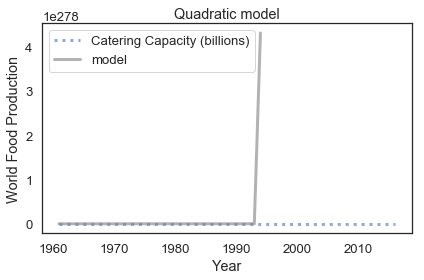

In [187]:
results = run_simulation2(system, update_func_quad)
plot_results2(Catering_Capacity_in_billions_of_people, results, 'Quadratic model')
savefig('figs/chap03-fig04.pdf')

# Method 2:
(i) Expenditure on food incurred per year

In [167]:
from pandas import read_csv
food_filename = read_csv("FAOSTAT_data_9-24-2018 (Meg).csv")
food_filename.columns = ['year', 'cost', 'people']
print(food_filename.head())
food_filename.cost = food_filename.cost/1000

   year         cost      people
0  1961  714535.6189  364.166961
1  1962  737263.3451  375.750270
2  1963  761384.0015  388.043493
3  1964  777157.7629  396.082677
4  1965  793165.5252  404.241120


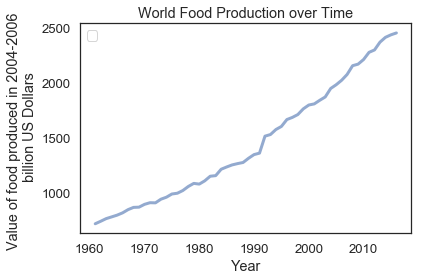

In [168]:
plot(food_filename.year, food_filename.cost)
decorate(title = "World Food Production over Time",
        xlabel = "Year",
        ylabel = "Value of food produced in 2004-2006 \n billion US Dollars")

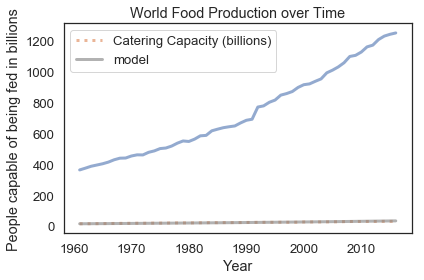

In [169]:
plot(food_filename.year, food_filename.people)
plot_results2(Catering_Capacity_in_billions_of_people, results, 'Proportional model, combined produce and waste')
decorate(title = "World Food Production over Time",
        xlabel = "Year",
        ylabel = "People capable of being fed in billions")